In [ ]:
!pip install pandas
!pip install numpy
!pip install django
!pip install models
!pip install scikit-learn
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.9 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement models (from versions: 0.0.3, 0.0.4, 0.0.5, 0.1.0, 0.1.1, 0.2.0, 0.3.0, 0.4.0, 0.7.0, 0.8.0, 0.9.0, 0.9.1, 0.9.2, 0.9.3)
ERROR: No matching distribution found for models
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision.transforms.functional import crop
from sklearn.model_selection import train_test_split
from django.db import models
import json
import os
import h5py
from typing import Tuple
import joblib
from google.colab import files
from pathlib import Path
from typing import Any
from matplotlib.lines import Line2D
%matplotlib inline

In [ ]:
def  get_config() -> dict:
  #The drive path:
  if os.path.exists('/content/drive/MyDrive/TFM/CONFIG.jason'):
    file_path= '/content/drive/MyDrive/TFM/CONFIG.jason'

  #The manual upload path:
  elif os.path.exists('/content/CONFIG.jason'):
    file_path='/content/CONFIG.jason'

  else:
    raise FileNotFoundError('Configuration file not found')

  with open(file_path, 'r') as config_file:
    config = json.load(config_file)

  return config

In [ ]:
def get_normalization_from_samplefile(file_path:str) ->dict:

  if not os.path.exists(file_path):
    raise FileNotFoundError(f'Sample file "{file_path}" does not exist!')

    with h5py.File(file_path,'r') as hdf_file:

      h1_mean = float(hdf_file['normalization_parameters'].attrs['h1_mean'])
      l1_mean = float(hdf_file['normalization_parameters'].attrs['l1_mean'])
      h1_std = float(hdf_file['normalization_parameters'].attrs['h1_std'])
      l1_std = float(hdf_file['normalization_parameters'].attrs['l1_std'])

      return dict(h1_mean=h1_mean, l1_mean=l1_mean, h1_std=h1_h1_std, l1_std=l1_std)


def get_samples_from_samplefile(source, cutoff, mode, file_path: str, normalization: dict=None, sample_type: str='both', label_length: float=0.2, cutoff_left: int=20147, cutoff_right: int=2048) ->Tuple[np.ndarray,np.ndarray]:

  if not os.path.exists(file_path):
    raise FileNotFoundError(f'Sampel file "{file_path}"does not exist!')

  if sample_type not in('injection', 'noise', 'both'):
    raise ValueError(f'Invalid for sample_type: {sample_type}')

    ##------------------------------------------------------------------------------------------
    ##    OPEN AND READ THE HDF FILE
    ##------------------------------------------------------------------------------------------

  with h5py.File(file_path,'r') as hdf_file:

    seconds_before_event=float(hdf_file['static_arguments'].attrs['seconds_before_event'])

    sampling_rate=float(hdf_file['static_arguments'].attrs['target_sampling_rate'])

    label_start = int((seconds_before_event-(0.5*label_length))*sampling_rate+1)

    label_end = int((seconds_before_event+(0.5*label_length))*sampling_rate+1)


    if sample_type in('injection', 'both'):
      inj_samples_h1=np.array(hdf_file['/injection_samples/h1_strain'])
      inj_samples_label=np.zeros(shape=inj_samples_h1.shape)
      inj_samples_label[:,label_start:label_end]=1
      if source!=0:
        inj_samples_l1=np.array(hdf_file['/injection_samples/l1_strain'])


    if sample_type in('noise', 'both'):
      noise_samples_h1=np.array(hdf_file['/noise_samples/h1_strain'])
      noise_samples_label=np.zeros(shape=noise_samples_h1.shape)
      if source!=0:
        noise_samples_l1=np.array(hdf_file['/noise_samples/l1_strain'])

    if sample_type=='injection':
      samples_h1=inj_samples_h1
      if source!=0:
        samples_l1=inj_samples_l1
      labels=inj_samples_label

    elif sample_type== 'noise':
      samples_h1=noise_samples_h1
      if source!=0:
        samples_l1=noise_samples_l1
      labels=noise_samples_label

    else:
      samples_h1=np.concatenate([inj_samples_h1, noise_samples_h1])
      del inj_samples_h1, noise_samples_h1
      labels=np.concatenate([inj_samples_label, noise_samples_label])
      del inj_samples_label, noise_samples_label
      if mode=='validation':
        length=samples_h1.shape[0]
        q=int(length/4)
        samples_h1=np.delete(samples_h1, slice(3*q,4*q),axis=0)
        samples_h1=np.delete(samples_h1, slice(0,q),axis=0)
        labels=np.delete(labels, slice(3*q,4*q),axis=0)
        labels=np.delete(labels, slice(0,q),axis=0)
      if source!=0:
        samples_l1=np.concatenate([inj_samples_l1, noise_samples_l1])


    if normalization is None:
      normalization={'h1_mean':0.0, 'h1_std':1.0,'l1_mean':0.0, 'l1_std':1.0}


    samples_h1=(samples_h1-normalization['h1_mean'])/normalization['h1_std']

    if source!=0:
      samples_l1=(samples_l1-normalization['l1_mean'])/normalization['l1_std']
      if mode=='validation':
        length=samples_l1.shape[0]
        q=int(length/4)
        samples_l1=np.delete(samples_l1, slice(3*q,4*q),axis=0)
        samples_l1=np.delete(samples_l1, slice(0,q),axis=0)
      samples=np.dstack([samples_h1, samples_l1])
      samples=np.swapaxes(samples,1,2)


    labels=np.expand_dims(labels,1).astype(np.float32)
    if cutoff == 1:
      if cutoff_right!=0:
        labels=labels[:,cutoff_left:-cutoff_right]

      else:
        labels=labels[:,cutoff_left:]

    #Cut samples to half so the code can finish faster:
    c=0
    if mode == 'training' and c==1:
      length=samples_h1.shape[0]
      h=int(length/2)
      samples_h1=np.delete(samples_h1, slice(0,h),axis=0)
      labels=np.delete(labels, slice(0,h),axis=0)
    if source==0:
      return samples_h1, labels
    else:
      return samples, labels









In [ ]:
class InjectionDataset(torch.utils.data.Dataset):
  def __init__(self, mode: str, sample_type:str='both'):

    if mode not in ("training", "validation", "testing"):
      raise ValueError('mode must be one of the following:' '"training", "validation" or "testing"!')

    config=get_config()
    data_paths=config['data']
    source =1
    cutoff=0

    normalization= get_normalization_from_samplefile(data_paths['training'])


    self.data, self.labels= get_samples_from_samplefile(source, cutoff, mode, file_path=data_paths[mode], normalization=normalization, sample_type=sample_type, label_length=0.2, cutoff_left=2047,cutoff_right=2048)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):

    data=torch.tensor(self.data[index]).float()
    labels=torch.tensor(self.labels[index]).float()

    return data,labels



In [ ]:
class CheckpointManager(object):

  def __init__(self, model: torch.nn.Module, optimizer: torch.optim.Optimizer, scheduler: Any, checkpoints_directory: str= '/content/drive/MyDrive/TFM/checkpoints', mode: str= 'min,', step_size: int = 1, last_epoch: int =-1, verbose: bool=True):
    if not isinstance(model, torch.nn.Module):
      raise TypeError(f'{type(model).__name__} is not a Module')

    if not isinstance(optimizer, torch.optim.Optimizer):
      raise TypeError(f'{type(optimizer).__name__} is not an Optimizer')

    if not scheduler.__module__ == 'torch.optim.lr_scheduler':
      raise TypeError(f'{type(scheduler).__name__} is not a Scheduler')

    self.model = model
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.checkpoints_directory = checkpoints_directory
    self.mode = mode
    self.step_size = step_size
    self.last_epoch = last_epoch
    self.verbose = verbose

    self.initialize_checkpoints_directory()
    self.best_metric = np.inf * (-1 if mode == 'max' else 1)

  def initialize_checkpoints_directory(self):

    Path(self.checkpoints_directory).mkdir(parents=True, exist_ok=True)

  def step(self, metric: float, epoch: int = None):

    if not epoch:
      epoch = self.last_epoch + 1
    self.last_epoch=epoch

      ##Save the best model checkpoint if applicable

    if(self.mode=="min" and metric<self.best_metric) or (self.mode=="max" and metric>self.best_metric):
      self.best_metric=metric
      self.save_checkpoint(checkpoint=self.get_current_checkpoint(), name='best_Unet_256_2ch.pth')

    ##Save regular checkpoint every stepsize epochs:

    if(self.step_size>0) and (self.last_epoch % self.step_size==0):
      self.save_checkpoint(checkpoint=self.get_current_checkpoint(), name=f'Unet_256__2ch_epoch_{epoch}.pth')

  def save_checkpoint(self, checkpoint: dict, name: str):
    torch.save(checkpoint, os.path.join(self.checkpoints_directory, name))

    if self.verbose:
      print(f'Saved checkpoint: {name}')

  def load_checkpoint(self, checkpoint_file_path: str):
    if not os.path.exists(checkpoint_file_path):
      raise FileNotFoundError(f'{checkpoint_file_path} does not exist')

    checkpoint= torch.load(checkpoint_file_path)
    print("...checkpoint file loaded")

    self.model.load_state_dict(checkpoint['model_state_dict'])
    print("...model loaded")
    self.optimizer.load_state_dict(checkpoint['optim_state_dict'])
    print("...optimizer loaded")
    self.scheduler.load_state_dict(checkpoint['sched_state_dict'])
    print("...scheduler loaded")

    self.last_epoch=checkpoint['last_epoch']
    self.best_metric=checkpoint['best_metric']

  def get_current_checkpoint(self):
    if isinstance(self.model, torch.nn.DataParallel):
      model_state_dict= self.model.module.state_dict()
    else:
      model_state_dict= self.model.state_dict()

    checkpoint= dict(model_state_dict=model_state_dict, optim_state_dict=self.optimizer.state_dict(), sched_state_dict=self.scheduler.state_dict(), best_metric=self.best_metric, last_epoch=self.last_epoch)

    return checkpoint

In [ ]:
class Unet1D(nn.Module):
    def __init__(self, in_ch: int):
        super(Unet1D,self).__init__()
        ##Descent block:
        self.conv1=nn.Conv1d(in_ch,64,10)
        self.conv11=nn.Conv1d(64,64,8)
        self.max1=nn.MaxPool1d(2,2)
        self.conv2=nn.Conv1d(64,128,8)
        self.conv22=nn.Conv1d(128,128,8)
        self.max2=nn.MaxPool1d(2,2)

        ##Bottom level:
        self.conv3=nn.Conv1d(128,256,8)
        self.conv33=nn.Conv1d(256,256,8)
        self.deconv1=nn.ConvTranspose1d(256,128,8)
        self.deconv11=nn.ConvTranspose1d(128,128,8)

        ##Ascent block:
        self.up1=nn.Upsample(scale_factor=2)
        self.deconv2=nn.ConvTranspose1d(256,128,8)
        self.deconv22=nn.ConvTranspose1d(128,64,8)
        self.up2=nn.Upsample(scale_factor=2)
        self.deconv3=nn.ConvTranspose1d(128,64,8)
        self.deconv33=nn.ConvTranspose1d(64,1,10)

    def forward(self,x):
        x=self.conv1(x)
        x=F.relu(x)
        x=self.conv11(x)
        x=F.relu(x)
        x_1=x
        x=self.max1(x)
        x=self.conv2(x)
        x=F.relu(x)
        x=self.conv22(x)
        x=F.relu(x)
        x_2=x
        x=self.max2(x)
        x=self.conv3(x)
        x=F.relu(x)
        x=self.conv33(x)
        x=F.relu(x)
        x=self.deconv1(x)
        x=F.relu(x)
        x=self.deconv11(x)
        x=F.relu(x)
        x=self.up1(x)
        x=torch.cat((x,x_2),1)
        x=self.deconv2(x)
        x=F.relu(x)
        x=self.deconv22(x)
        x=F.relu(x)
        x=self.up2(x)
        x=torch.cat((x,x_1),1)
        x=self.deconv3(x)
        x=F.relu(x)
        x=self.deconv33(x)
        x=torch.sigmoid(x)
        return x


In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
t_batch_size=64
v_batch_size=32

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model= Unet1D(in_ch=2)
model.to(device)
optimizer=optim.Adam(model.parameters(),lr=5e-5)
#learning rate
lr_sched=lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
summary(model, input_size=(2,16384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 64, 16375]           1,344
            Conv1d-2            [-1, 64, 16368]          32,832
         MaxPool1d-3             [-1, 64, 8184]               0
            Conv1d-4            [-1, 128, 8177]          65,664
            Conv1d-5            [-1, 128, 8170]         131,200
         MaxPool1d-6            [-1, 128, 4085]               0
            Conv1d-7            [-1, 256, 4078]         262,400
            Conv1d-8            [-1, 256, 4071]         524,544
   ConvTranspose1d-9            [-1, 128, 4078]         262,272
  ConvTranspose1d-10            [-1, 128, 4085]         131,200
         Upsample-11            [-1, 128, 8170]               0
  ConvTranspose1d-12            [-1, 128, 8177]         262,272
  ConvTranspose1d-13             [-1, 64, 8184]          65,600
         Upsample-14            [-1, 64

In [ ]:
training_dataset=InjectionDataset(mode='training')
training_dataloader=torch.utils.data.DataLoader(training_dataset, batch_size=t_batch_size, shuffle=True)
print(training_dataset.data.shape)
print(training_dataset.labels.shape)
n_t_batches=training_dataset.data.shape[0]/t_batch_size
print("number of training batches:",n_t_batches)

(32768, 2, 16384)
(32768, 1, 16384)
number of training batches: 512.0


In [ ]:
del training_dataset

In [ ]:
validation_dataset=InjectionDataset(mode='validation')
validation_dataloader=torch.utils.data.DataLoader(validation_dataset, batch_size=v_batch_size, shuffle=True)
print(validation_dataset.data.shape)
print(validation_dataset.labels.shape)
#del validation_dataset
n_v_batches=validation_dataset.data.shape[0]/v_batch_size
print("number of validation batches:",n_v_batches)

(2048, 2, 16384)
(2048, 1, 16384)
number of validation batches: 64.0


In [ ]:
del validation_dataset

checking for checkpoint to load...
...checkpoint file loaded
...model loaded
...optimizer loaded
...scheduler loaded
best metric: 0.0351614783576224
epoch: 38 , training batch: 1
epoch: 38 , training batch: 2
epoch: 38 , training batch: 3
epoch: 38 , training batch: 4
epoch: 38 , training batch: 5
epoch: 38 , training batch: 6
epoch: 38 , training batch: 7
epoch: 38 , training batch: 8
epoch: 38 , training batch: 9
epoch: 38 , training batch: 10
epoch: 38 , training batch: 11
epoch: 38 , training batch: 12
epoch: 38 , training batch: 13
epoch: 38 , training batch: 14
epoch: 38 , training batch: 15
epoch: 38 , training batch: 16
epoch: 38 , training batch: 17
epoch: 38 , training batch: 18
epoch: 38 , training batch: 19
epoch: 38 , training batch: 20
epoch: 38 , training batch: 21
epoch: 38 , training batch: 22
epoch: 38 , training batch: 23
epoch: 38 , training batch: 24
epoch: 38 , training batch: 25
epoch: 38 , training batch: 26
epoch: 38 , training batch: 27
epoch: 38 , training ba

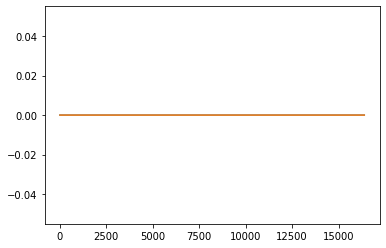

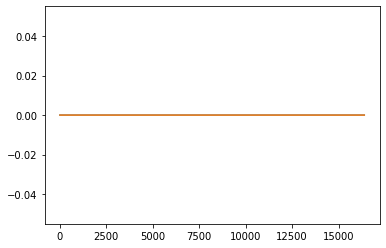

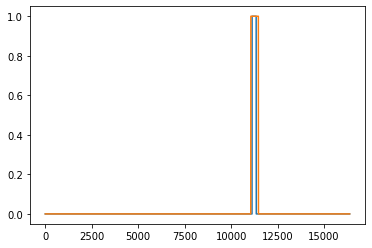

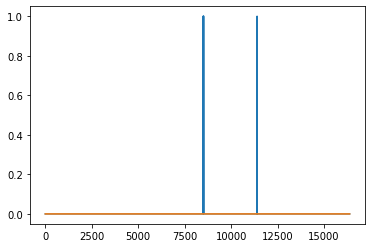

FPs per vbatch [0.1904296875]
detection ratio: [0.8486328125]
accuracy: [99.31797385215759]
t_loss: [0.04609189100301592]
v_loss: [0.03593174877460115]
38
total train batches: 513
epoch: 39 , training batch: 1
epoch: 39 , training batch: 2
epoch: 39 , training batch: 3
epoch: 39 , training batch: 4
epoch: 39 , training batch: 5
epoch: 39 , training batch: 6
epoch: 39 , training batch: 7
epoch: 39 , training batch: 8
epoch: 39 , training batch: 9
epoch: 39 , training batch: 10
epoch: 39 , training batch: 11
epoch: 39 , training batch: 12
epoch: 39 , training batch: 13
epoch: 39 , training batch: 14
epoch: 39 , training batch: 15
epoch: 39 , training batch: 16
epoch: 39 , training batch: 17
epoch: 39 , training batch: 18
epoch: 39 , training batch: 19
epoch: 39 , training batch: 20
epoch: 39 , training batch: 21
epoch: 39 , training batch: 22
epoch: 39 , training batch: 23
epoch: 39 , training batch: 24
epoch: 39 , training batch: 25
epoch: 39 , training batch: 26
epoch: 39 , training ba

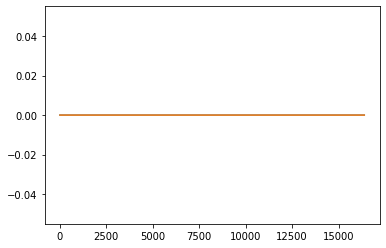

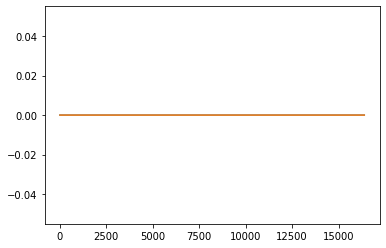

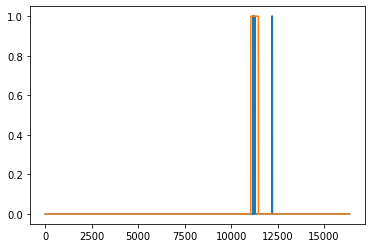

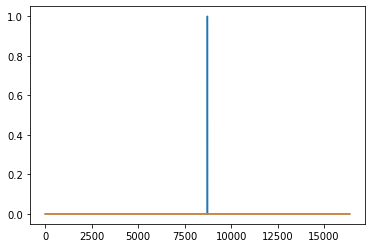

FPs per vbatch [0.41064453125]
detection ratio: [0.8486328125, 0.8408203125]
accuracy: [99.31797385215759, 99.32025671005249]
t_loss: [0.04609189100301592, 0.04611002940509934]
v_loss: [0.03593174877460115, 0.03603135250159539]
39
total train batches: 513
epoch: 40 , training batch: 1
epoch: 40 , training batch: 2
epoch: 40 , training batch: 3
epoch: 40 , training batch: 4
epoch: 40 , training batch: 5
epoch: 40 , training batch: 6
epoch: 40 , training batch: 7
epoch: 40 , training batch: 8
epoch: 40 , training batch: 9
epoch: 40 , training batch: 10
epoch: 40 , training batch: 11
epoch: 40 , training batch: 12
epoch: 40 , training batch: 13
epoch: 40 , training batch: 14
epoch: 40 , training batch: 15
epoch: 40 , training batch: 16
epoch: 40 , training batch: 17
epoch: 40 , training batch: 18
epoch: 40 , training batch: 19
epoch: 40 , training batch: 20
epoch: 40 , training batch: 21
epoch: 40 , training batch: 22
epoch: 40 , training batch: 23
epoch: 40 , training batch: 24
epoch: 40

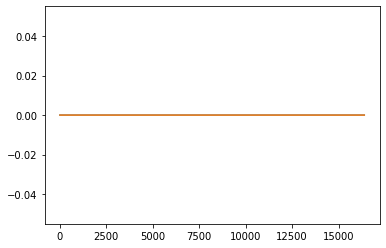

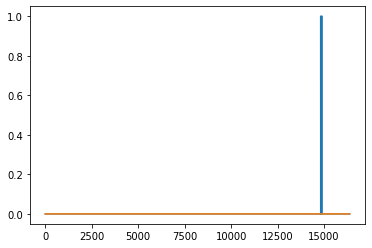

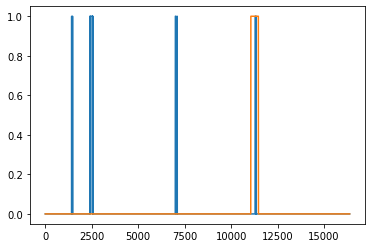

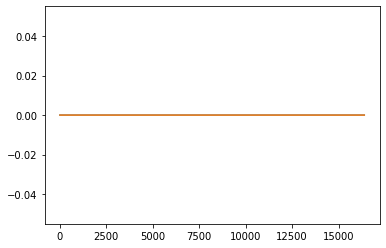

FPs per vbatch [0.2392578125]
detection ratio: [0.8486328125, 0.8408203125, 0.8427734375]
accuracy: [99.31797385215759, 99.32025671005249, 99.3217945098877]
t_loss: [0.04609189100301592, 0.04611002940509934, 0.04603607241733698]
v_loss: [0.03593174877460115, 0.03603135250159539, 0.03551879327278584]
40
total train batches: 513
epoch: 41 , training batch: 1
epoch: 41 , training batch: 2
epoch: 41 , training batch: 3
epoch: 41 , training batch: 4
epoch: 41 , training batch: 5
epoch: 41 , training batch: 6
epoch: 41 , training batch: 7
epoch: 41 , training batch: 8
epoch: 41 , training batch: 9
epoch: 41 , training batch: 10
epoch: 41 , training batch: 11
epoch: 41 , training batch: 12
epoch: 41 , training batch: 13
epoch: 41 , training batch: 14
epoch: 41 , training batch: 15
epoch: 41 , training batch: 16
epoch: 41 , training batch: 17
epoch: 41 , training batch: 18
epoch: 41 , training batch: 19
epoch: 41 , training batch: 20
epoch: 41 , training batch: 21
epoch: 41 , training batch: 2

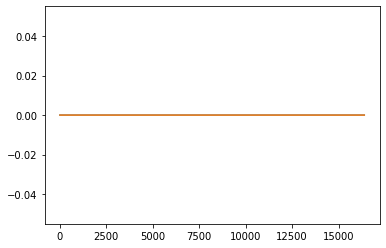

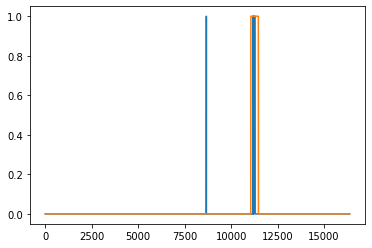

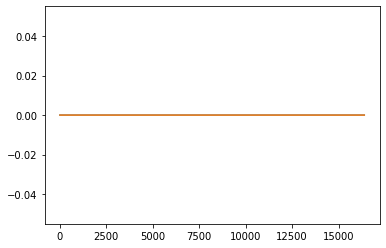

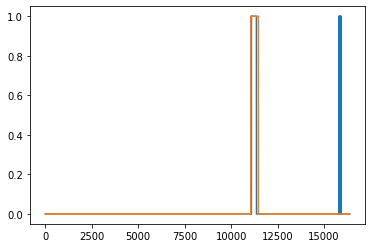

FPs per vbatch [0.1650390625]
detection ratio: [0.8486328125, 0.8408203125, 0.8427734375, 0.8369140625]
accuracy: [99.31797385215759, 99.32025671005249, 99.3217945098877, 99.32532012462616]
t_loss: [0.04609189100301592, 0.04611002940509934, 0.04603607241733698, 0.045980222246726044]
v_loss: [0.03593174877460115, 0.03603135250159539, 0.03551879327278584, 0.035310234990902245]
41
total train batches: 513
epoch: 42 , training batch: 1
epoch: 42 , training batch: 2
epoch: 42 , training batch: 3
epoch: 42 , training batch: 4
epoch: 42 , training batch: 5
epoch: 42 , training batch: 6
epoch: 42 , training batch: 7
epoch: 42 , training batch: 8
epoch: 42 , training batch: 9
epoch: 42 , training batch: 10
epoch: 42 , training batch: 11
epoch: 42 , training batch: 12
epoch: 42 , training batch: 13
epoch: 42 , training batch: 14
epoch: 42 , training batch: 15
epoch: 42 , training batch: 16
epoch: 42 , training batch: 17
epoch: 42 , training batch: 18
epoch: 42 , training batch: 19
epoch: 42 , tr

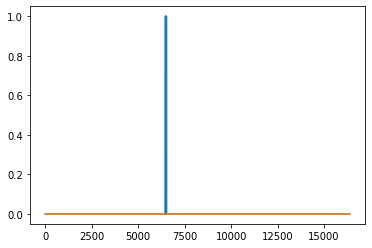

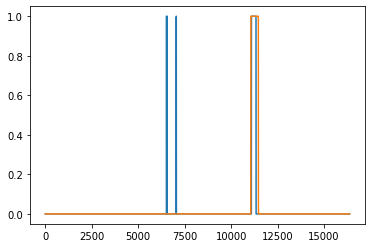

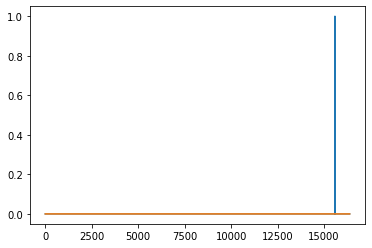

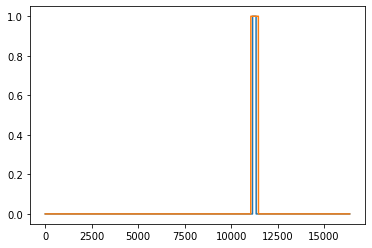

FPs per vbatch [0.13916015625]
detection ratio: [0.8486328125, 0.8408203125, 0.8427734375, 0.8369140625, 0.8251953125]
accuracy: [99.31797385215759, 99.32025671005249, 99.3217945098877, 99.32532012462616, 99.32760000228882]
t_loss: [0.04609189100301592, 0.04611002940509934, 0.04603607241733698, 0.045980222246726044, 0.0459628271200927]
v_loss: [0.03593174877460115, 0.03603135250159539, 0.03551879327278584, 0.035310234990902245, 0.035289727384224534]
42
total train batches: 513
epoch: 43 , training batch: 1
epoch: 43 , training batch: 2
epoch: 43 , training batch: 3
epoch: 43 , training batch: 4
epoch: 43 , training batch: 5
epoch: 43 , training batch: 6
epoch: 43 , training batch: 7
epoch: 43 , training batch: 8
epoch: 43 , training batch: 9
epoch: 43 , training batch: 10
epoch: 43 , training batch: 11
epoch: 43 , training batch: 12
epoch: 43 , training batch: 13
epoch: 43 , training batch: 14
epoch: 43 , training batch: 15
epoch: 43 , training batch: 16
epoch: 43 , training batch: 17


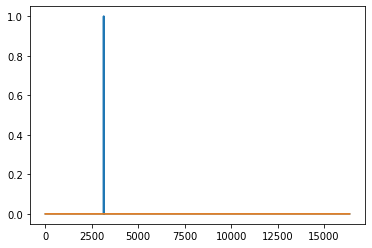

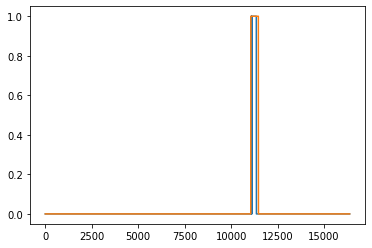

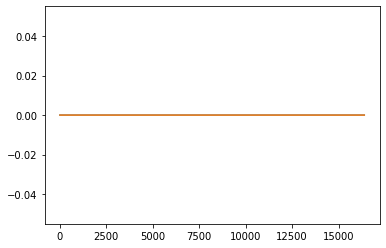

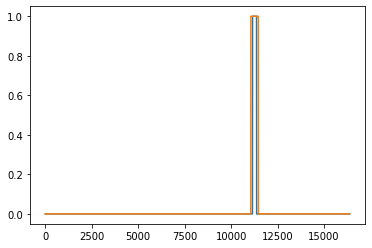

FPs per vbatch [0.04443359375]
detection ratio: [0.8486328125, 0.8408203125, 0.8427734375, 0.8369140625, 0.8251953125, 0.8349609375]
accuracy: [99.31797385215759, 99.32025671005249, 99.3217945098877, 99.32532012462616, 99.32760000228882, 99.32576715946198]
t_loss: [0.04609189100301592, 0.04611002940509934, 0.04603607241733698, 0.045980222246726044, 0.0459628271200927, 0.04583064885082422]
v_loss: [0.03593174877460115, 0.03603135250159539, 0.03551879327278584, 0.035310234990902245, 0.035289727384224534, 0.03534109142492525]
43
total train batches: 513
epoch: 44 , training batch: 1
epoch: 44 , training batch: 2
epoch: 44 , training batch: 3
epoch: 44 , training batch: 4
epoch: 44 , training batch: 5
epoch: 44 , training batch: 6
epoch: 44 , training batch: 7
epoch: 44 , training batch: 8
epoch: 44 , training batch: 9
epoch: 44 , training batch: 10
epoch: 44 , training batch: 11
epoch: 44 , training batch: 12
epoch: 44 , training batch: 13
epoch: 44 , training batch: 14
epoch: 44 , traini

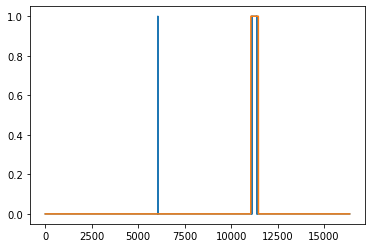

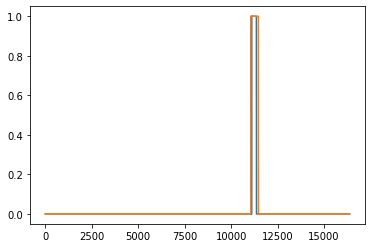

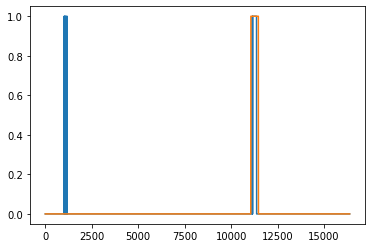

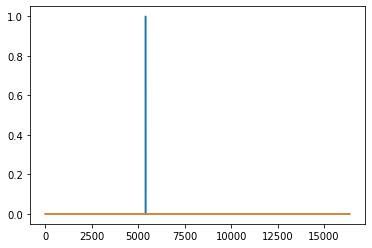

FPs per vbatch [0.18115234375]
detection ratio: [0.8486328125, 0.8408203125, 0.8427734375, 0.8369140625, 0.8251953125, 0.8349609375, 0.841796875]
accuracy: [99.31797385215759, 99.32025671005249, 99.3217945098877, 99.32532012462616, 99.32760000228882, 99.32576715946198, 99.3223488330841]
t_loss: [0.04609189100301592, 0.04611002940509934, 0.04603607241733698, 0.045980222246726044, 0.0459628271200927, 0.04583064885082422, 0.045825613611668814]
v_loss: [0.03593174877460115, 0.03603135250159539, 0.03551879327278584, 0.035310234990902245, 0.035289727384224534, 0.03534109142492525, 0.03559025135473348]
44
total train batches: 513
epoch: 45 , training batch: 1
epoch: 45 , training batch: 2
epoch: 45 , training batch: 3
epoch: 45 , training batch: 4
epoch: 45 , training batch: 5
epoch: 45 , training batch: 6
epoch: 45 , training batch: 7
epoch: 45 , training batch: 8
epoch: 45 , training batch: 9
epoch: 45 , training batch: 10
epoch: 45 , training batch: 11
epoch: 45 , training batch: 12
epoch:

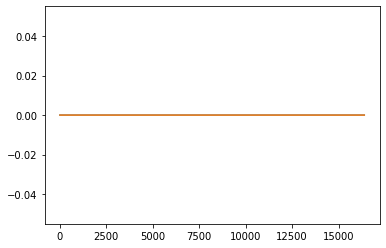

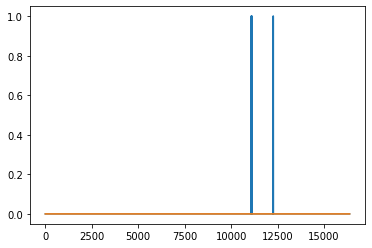

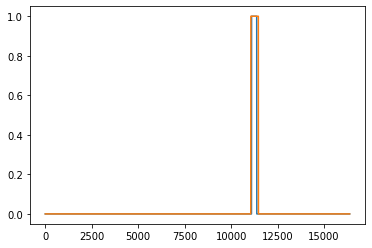

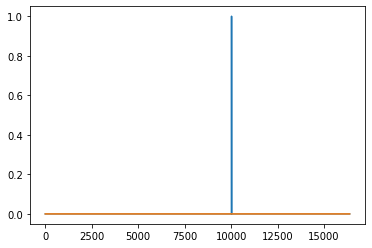

FPs per vbatch [0.1083984375]
detection ratio: [0.8486328125, 0.8408203125, 0.8427734375, 0.8369140625, 0.8251953125, 0.8349609375, 0.841796875, 0.841796875]
accuracy: [99.31797385215759, 99.32025671005249, 99.3217945098877, 99.32532012462616, 99.32760000228882, 99.32576715946198, 99.3223488330841, 99.32179749011993]
t_loss: [0.04609189100301592, 0.04611002940509934, 0.04603607241733698, 0.045980222246726044, 0.0459628271200927, 0.04583064885082422, 0.045825613611668814, 0.04581925863021752]
v_loss: [0.03593174877460115, 0.03603135250159539, 0.03551879327278584, 0.035310234990902245, 0.035289727384224534, 0.03534109142492525, 0.03559025135473348, 0.03562353571760468]
45
total train batches: 513
epoch: 46 , training batch: 1
epoch: 46 , training batch: 2
epoch: 46 , training batch: 3
epoch: 46 , training batch: 4
epoch: 46 , training batch: 5
epoch: 46 , training batch: 6
epoch: 46 , training batch: 7
epoch: 46 , training batch: 8
epoch: 46 , training batch: 9
epoch: 46 , training batch

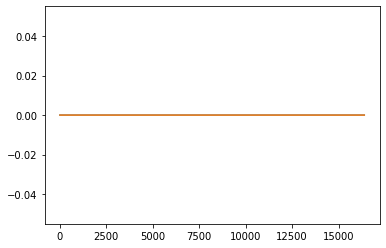

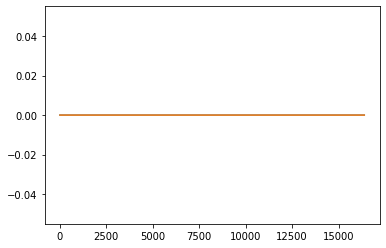

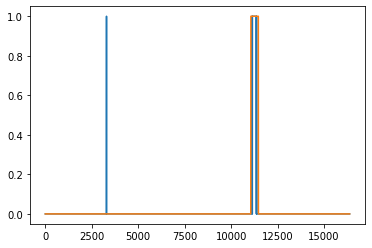

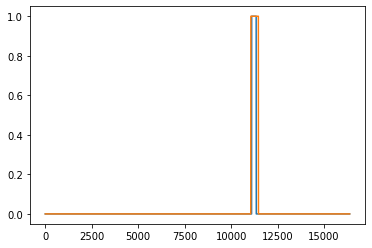

FPs per vbatch [0.15283203125]
detection ratio: [0.8486328125, 0.8408203125, 0.8427734375, 0.8369140625, 0.8251953125, 0.8349609375, 0.841796875, 0.841796875, 0.83984375]
accuracy: [99.31797385215759, 99.32025671005249, 99.3217945098877, 99.32532012462616, 99.32760000228882, 99.32576715946198, 99.3223488330841, 99.32179749011993, 99.32258129119873]
t_loss: [0.04609189100301592, 0.04611002940509934, 0.04603607241733698, 0.045980222246726044, 0.0459628271200927, 0.04583064885082422, 0.045825613611668814, 0.04581925863021752, 0.045814785655238666]
v_loss: [0.03593174877460115, 0.03603135250159539, 0.03551879327278584, 0.035310234990902245, 0.035289727384224534, 0.03534109142492525, 0.03559025135473348, 0.03562353571760468, 0.035570290667237714]
46
total train batches: 513
epoch: 47 , training batch: 1
epoch: 47 , training batch: 2
epoch: 47 , training batch: 3
epoch: 47 , training batch: 4
epoch: 47 , training batch: 5
epoch: 47 , training batch: 6
epoch: 47 , training batch: 7
epoch: 47 

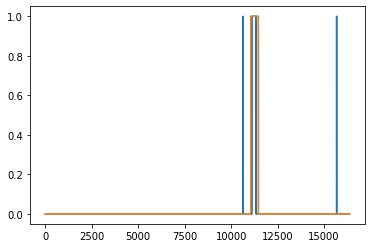

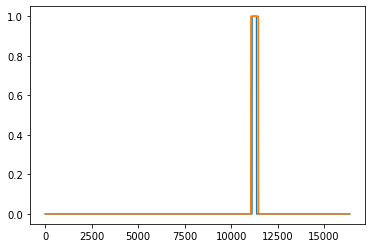

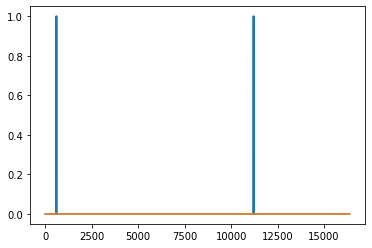

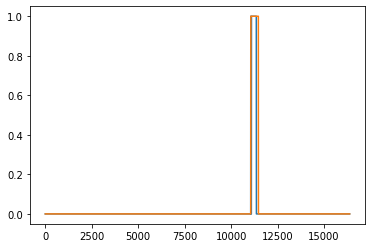

FPs per vbatch [0.1982421875]
detection ratio: [0.8486328125, 0.8408203125, 0.8427734375, 0.8369140625, 0.8251953125, 0.8349609375, 0.841796875, 0.841796875, 0.83984375, 0.8447265625]
accuracy: [99.31797385215759, 99.32025671005249, 99.3217945098877, 99.32532012462616, 99.32760000228882, 99.32576715946198, 99.3223488330841, 99.32179749011993, 99.32258129119873, 99.3214100599289]
t_loss: [0.04609189100301592, 0.04611002940509934, 0.04603607241733698, 0.045980222246726044, 0.0459628271200927, 0.04583064885082422, 0.045825613611668814, 0.04581925863021752, 0.045814785655238666, 0.045809330891643185]
v_loss: [0.03593174877460115, 0.03603135250159539, 0.03551879327278584, 0.035310234990902245, 0.035289727384224534, 0.03534109142492525, 0.03559025135473348, 0.03562353571760468, 0.035570290667237714, 0.03563642091467045]
47
total train batches: 513
epoch: 48 , training batch: 1
epoch: 48 , training batch: 2
epoch: 48 , training batch: 3
epoch: 48 , training batch: 4
epoch: 48 , training batch

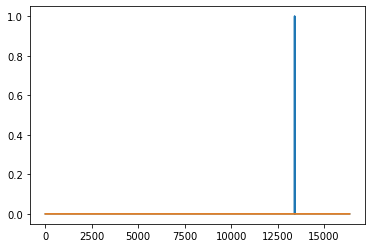

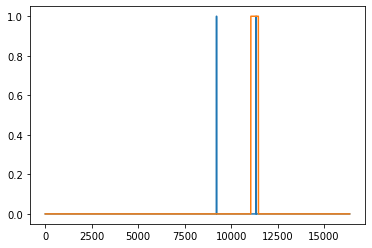

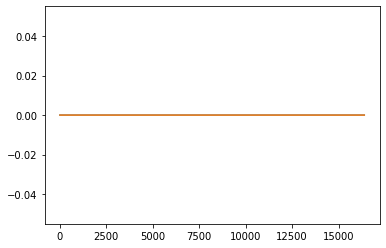

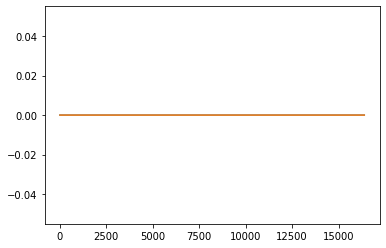

FPs per vbatch [0.11767578125]
detection ratio: [0.8486328125, 0.8408203125, 0.8427734375, 0.8369140625, 0.8251953125, 0.8349609375, 0.841796875, 0.841796875, 0.83984375, 0.8447265625, 0.83984375]
accuracy: [99.31797385215759, 99.32025671005249, 99.3217945098877, 99.32532012462616, 99.32760000228882, 99.32576715946198, 99.3223488330841, 99.32179749011993, 99.32258129119873, 99.3214100599289, 99.32395219802856]
t_loss: [0.04609189100301592, 0.04611002940509934, 0.04603607241733698, 0.045980222246726044, 0.0459628271200927, 0.04583064885082422, 0.045825613611668814, 0.04581925863021752, 0.045814785655238666, 0.045809330891643185, 0.045805346519046]
v_loss: [0.03593174877460115, 0.03603135250159539, 0.03551879327278584, 0.035310234990902245, 0.035289727384224534, 0.03534109142492525, 0.03559025135473348, 0.03562353571760468, 0.035570290667237714, 0.03563642091467045, 0.0354317020974122]
48
total train batches: 513
epoch: 49 , training batch: 1
epoch: 49 , training batch: 2
epoch: 49 , tra

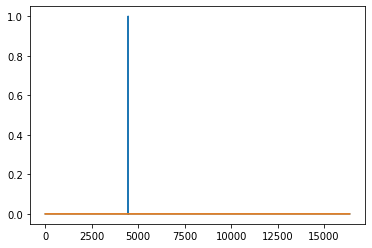

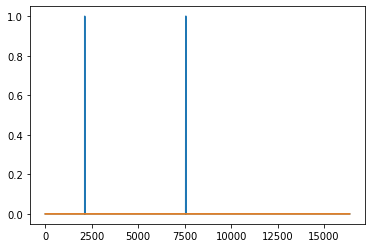

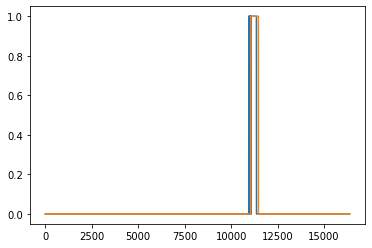

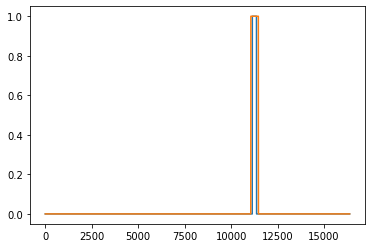

FPs per vbatch [0.31201171875]
detection ratio: [0.8486328125, 0.8408203125, 0.8427734375, 0.8369140625, 0.8251953125, 0.8349609375, 0.841796875, 0.841796875, 0.83984375, 0.8447265625, 0.83984375, 0.8408203125]
accuracy: [99.31797385215759, 99.32025671005249, 99.3217945098877, 99.32532012462616, 99.32760000228882, 99.32576715946198, 99.3223488330841, 99.32179749011993, 99.32258129119873, 99.3214100599289, 99.32395219802856, 99.3223786354065]
t_loss: [0.04609189100301592, 0.04611002940509934, 0.04603607241733698, 0.045980222246726044, 0.0459628271200927, 0.04583064885082422, 0.045825613611668814, 0.04581925863021752, 0.045814785655238666, 0.045809330891643185, 0.045805346519046, 0.04580135876312852]
v_loss: [0.03593174877460115, 0.03603135250159539, 0.03551879327278584, 0.035310234990902245, 0.035289727384224534, 0.03534109142492525, 0.03559025135473348, 0.03562353571760468, 0.035570290667237714, 0.03563642091467045, 0.0354317020974122, 0.03553779088542797]
49
total train batches: 513


In [ ]:
####----------------------------------------------------------------------------------------
###           MAIN CODE: TRAIN THE MODEL
###-----------------------------------------------------------------------------------------

n_epochs=50
train_Loss_list=[]
valid_Loss_list=[]
accuracy_list=[]
D=[]
valid_len=512
cnt=1
resume=1
n_val=0
checkpoint_manager = CheckpointManager(model=model, optimizer=optimizer, scheduler=lr_sched, mode='min', step_size=-1)
if resume==1:
    print("checking for checkpoint to load...")
    checkpoint_manager.load_checkpoint('/content/drive/MyDrive/TFM/checkpoints/best_Unet_256_2ch.pth')
    epoch= checkpoint_manager.last_epoch
    print("best metric:", checkpoint_manager.best_metric)
else:
    epoch=0
while epoch < n_epochs:

    train_loss = 0.0
    valid_loss = 0.0
    correct = 0.0
    sbcnt=1

    for batch_indx, (data, target) in enumerate(training_dataloader):
        model.train()
        #data=data.reshape(-1,1,16384)
        #target= target.reshape(-1,1,16384)
        #print("data shape:", data.shape)
        #print("target shape:", target.shape)
        data, target= data.to(device).float(), target.to(device).float()
        #data, target= data.float(), target.float()
        optimizer.zero_grad()
        output=model(data)
        loss=F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        zero_vecs=0
        print("epoch:", epoch, ", training batch:",sbcnt)
        sbcnt+=1
        #validation:

        if (batch_indx+1)%valid_len==0:
            n_val+=1
            acc_sum=0
            model.eval()
            vbatch=0
            det=0
            FP=[]
            t_zero_vecs=0
            for data, target in validation_dataloader:
                #data=data.reshape(-1,1,16384)
                #target= target.reshape(-1,1,16384)
                data, target = data.to(device).float(), target.to(device).float()
                #data, target= data.float(), target.float()
                output=model(data)
                loss = F.binary_cross_entropy(output, target)
                valid_loss += loss.item()*data.size(0)
                correct_tensor=torch.rand(output.shape)
                zero_vecs=0
                t_size=correct_tensor.shape[2]
                rows=correct_tensor.shape[0]
                a_s=0
                VM=[]
                TN=[]
                d=0
                fp=0
                threshold=0.5
                correct_tensor = (output > threshold).float()
                for i in range(output.size(dim=0)):
                    p=0
                    match=0
                    tp=0
                    for j in range(output.size(dim=2)):
                        if correct_tensor[i,0,j]==target[i,0,j]:
                            match+=1
                            if target[i,0,j]==1:
                                tp+=1
                        elif correct_tensor[i,0,j]==1:
                            fp+=1
                        else:
                            TN.append([i,j])
                        if target[i,0,j]==1:
                            p+=1
                    if tp>100:
                      d+=1

                    if p==0:
                        zero_vecs+=1
                    accuracy=match/t_size
                    acc_sum+=accuracy
                t_zero_vecs+=zero_vecs
                print(zero_vecs," zero vectors in validation batch ", vbatch)
                print("correct tensor shape:",correct_tensor.shape)
                correct = np.squeeze(correct_tensor.cpu().numpy())
                print("correct shape:",correct.shape)
                #Now we calculate the accuracy of each temporal series so we can later average all of them for each batch

                det+=d
                vbatch+=1
                batch_accuracy=acc_sum/rows
                #print("batch accuracy:", batch_accuracy)
                print(d,"detections in vbatch", vbatch)
                #print(total_rows,"rows in validation batch",vbatch)
                #print("raw output:")
                #print(output)
                #print("correct tensor:")
                #print(correct_tensor)
                #print("visible matches:",VM)
                #print("True negatives:", TN)
                #print("matches on last row: ",match)
                #print("target:")
                #print(target)
                #print("data:")
                #print(data)
            for a in range(4):
                x=correct_tensor[a,0].cpu()
                y=range(len(x))
                xx=target[a,0].cpu()
                yy=range(len(xx))
                plt.plot(y,x)
                plt.plot(yy,xx)
                plt.show()
            det_ratio=det/(len(validation_dataloader.dataset)-t_zero_vecs)
            #Sanity check on output tensors:
            #print("raw output:", output)
            #print("correct tensor:",correct_tensor)
            #print("target:", target)
            #Calculate accuracy:
            t_rows=len(validation_dataloader.dataset)
            #print("t_rows:", t_rows)
            FP.append(fp/t_rows)
            tot_acc=100*(acc_sum/t_rows)
            #Calculate losses:
            train_loss=train_loss/(valid_len*t_batch_size)
            valid_loss = valid_loss / len(validation_dataloader.dataset)
            #curve data:
            D.append(det_ratio)
            train_Loss_list.append(train_loss)
            valid_Loss_list.append(valid_loss)
            accuracy_list.append(tot_acc)
            print("FPs per vbatch",FP)
            print("detection ratio:", D)
            print("accuracy:",accuracy_list)
            print("t_loss:",train_Loss_list)
            print("v_loss:",valid_Loss_list)


            checkpoint_manager.step(metric=valid_loss, epoch=epoch)
            print(checkpoint_manager.last_epoch)

            train_loss=0.0
            valid_loss=0.0
    print("total train batches:", sbcnt)
    lr_sched.step()
    cnt+=1
    #n_t_batches=512
    vals_per_epoch=n_t_batches/valid_len
    if vals_per_epoch>1.5:
        valid_len=valid_len*2
    epoch+=1

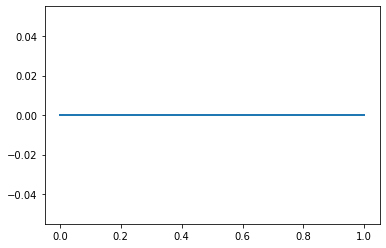

In [ ]:
#TEST:
output = (output >= threshold).float()
output=output.cpu()
plt.plot(output[0,0],target[1,0].cpu())
plt.show()

In [ ]:
print(output)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')


In [ ]:
## -----------------------------------------------
## WE APPLY THE MODEL TO THE TESTING DATASET
## -----------------------------------------------

from tqdm import tqdm
workers=8
batch_size=64
config = get_config()
checkpoint_path='/content/drive/MyDrive/TFM/checkpoints/best_Unet_256_2ch.pth'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Create a new instance of the model we have previously trained
model= Unet1D(in_ch=2)
print('model: \t\t\t', model.__class__.__name__)

# Make sure the checkpoint we want to load exists!
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f'{checkpoint_path} does not exist!')

# Read the checkpoint file and load the model_state_dict
checkpoint_manager = CheckpointManager(model=model, optimizer=optimizer, scheduler=lr_sched, mode='min', step_size=-1)
checkpoint_manager.load_checkpoint(checkpoint_path)
model.to(device)
model = torch.nn.DataParallel(model)


datasets = dict()
dataloaders = dict()

# Define options for the dataloader (same for all)
dataloader_options = dict(batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

for sample_type in ('injection', 'noise'):

    # Get examples with injections and construct a dataloader from it
    datasets[sample_type] = InjectionDataset(mode='testing', sample_type=sample_type)

    dataloaders[sample_type] = torch.utils.data.DataLoader(dataset=datasets[sample_type], **dataloader_options)

# Make sure the results directory exists
results_dir = '/content/drive/MyDrive/TFM/results/U-Net_results'
Path(results_dir).mkdir(exist_ok=True)

# Construct the path to the file that holds all predictions
predictions_file_name = 'U_predictions_testing_2ch_50ep.hdf'
predictions_file_path = os.path.join(results_dir, predictions_file_name)

# Activate evaluation mode for the model
model.eval()

# Keep track of the predictions we are producing
predictions = {sample_type: list() for sample_type in dataloaders.keys()}

for dataset_name in dataloaders.keys():

    # At test time, we do not need to compute gradients
    print(f'Making predictions for "{dataset_name}":')
    with torch.no_grad():

        # Loop in mini batches over the validation dataset
        for data, target in tqdm(iterable=dataloaders[dataset_name], total=len(dataloaders[dataset_name]), ncols=80):

            # Fetch batch data and move to device


            data = data.to(device)
            target = target.to(device).squeeze()


            # Compute the forward pass through the model
            output = model.forward(data).squeeze()

            # Store the predictions (as a numpy array)
            predictions[dataset_name].append(output.cpu().numpy())

    # Convert the list of predictions into a numpy array
    predictions[dataset_name] = np.vstack(predictions[dataset_name])

    # Save the predictions to the output HDF file
    print('Saving predictions to HDF file...', end=' ')
    with h5py.File(predictions_file_path, 'a') as hdf_file:

        # Delete the dataset if it already exists
        if dataset_name in hdf_file.keys():
            del hdf_file[dataset_name]

        # Create a new dataset holding the predictions
        hdf_file.create_dataset(name=dataset_name,
                                    data=predictions[dataset_name])
    print('Done!\n')


model: 			 Unet1D
...checkpoint file loaded
...model loaded
...optimizer loaded
...scheduler loaded
Making predictions for "injection":


100%|█████████████████████████████████████████| 128/128 [00:24<00:00,  5.30it/s]


Saving predictions to HDF file... Done!

Making predictions for "noise":


100%|█████████████████████████████████████████| 128/128 [00:23<00:00,  5.39it/s]


Saving predictions to HDF file... Done!



In [ ]:
###--------------------------------------------------------------------------------------
#                THE EVALUATION FUNCTIONS
#----------------------------------------------------------------------------------------

from typing import Dict, Optional, Tuple

def find_binary_peaks(array: np.ndarray)->np.ndarray:

  array = np.hstack(([0], array, [0]))
  differences = np.diff(array.astype(int))
  starts = np.where(differences==1)[0]
  ends = np.where(differences==-1)[0]
  return np.mean(np.vstack((starts,ends)), axis=0)-0.5

def postprocess_prediction(prediction: np.ndarray, threshold: float=0.5, window_size: int=256) ->np.ndarray:
  if prediction.ndim!=1:
    raise ValueError("Input should be 1D but is", prediction.ndim)

  kernel=np.full(window_size, 1.0/window_size)
  output=(np.convolve(prediction,kernel, mode='same'))

  # Round the raw outputs based on the provided threshold
  output = (output >= threshold).astype(np.float)

  return output

def get_detections_and_fp(predictions: np.ndarray, event_index: Optional[int], slack_width: Optional[int], window_size:int=256, threshold: float=0.5) -> Tuple[np.ndarray, np.ndarray]:

  detected_flags=list()
  false_positives=list()

  for prediction in predictions:

    postprocessed=postprocess_prediction(prediction=prediction, window_size=window_size, threshold=threshold)
    all_peaks=find_binary_peaks(postprocessed)

    if event_index is None:
      false_positives.append(len(all_peaks))
      continue

    else:
      detected=any([np.abs(event_index-peak)<slack_width for peak in all_peaks])
      detected_flags.append(detected)

      # Compute and store the number of false positives
      false_positives.append(len(all_peaks) - detected)

  return np.array(detected_flags), np.array(false_positives)

def get_dr_and_fpr(detected_flags: np.ndarray, false_positives: Dict[str, np.ndarray], sample_length: float)->Dict[str, float]:
  print(false_positives.values())
  n_samples_total = sum([len(_) for _ in false_positives.values()])
  n_false_positives = sum([np.sum(_) for _ in false_positives.values()])
  n_all_triggers = sum(detected_flags) + n_false_positives
  total_rec_time = sample_length * n_samples_total

  detection_ratio = np.mean(detected_flags)
  false_positive_ratio = n_false_positives / n_all_triggers
  false_positive_rate = n_false_positives / total_rec_time

  # Return the results as a dictionary
  return dict(detection_ratio=detection_ratio, false_positive_ratio=false_positive_ratio, false_positive_rate=false_positive_rate)

def get_avg_event_time_deviation(predictions: np.ndarray, event_index: int, slack_width: int, sampling_rate: int, window_size: int = 256, threshold: float = 0.5) -> Tuple[float,float]:

  deviations=[]
  for prediction in predictions:

    # Apply post-processing steps (smoothing, thresholding)
    postprocessed = postprocess_prediction(prediction=prediction,
                                               window_size=window_size,
                                               threshold=threshold)

    # Find all the peaks in the post-processed prediction
    all_peaks = find_binary_peaks(postprocessed)

    # Get the time difference to the ground truth for every peak
    differences = [np.abs(event_index - peak) for peak in all_peaks]

    # We only look at the peak that is closest to the ground truth
    # injection time. If this one is within the acceptance region, we
    # store its difference (in seconds); otherwise---if it is not
    # recovered---we just store NaN so that we can exclude it when
    # computing the mean and the standard deviation.
    if differences and min(differences) < slack_width:
      deviations.append(min(differences) / sampling_rate)
    else:
      deviations.append(np.nan)

  # Convert deviations to a numpy array and compute mean and std while
  # ignoring all examples where the injection as not recovered
  deviations = np.array(deviations)
  mean = float(np.nanmean(deviations))
  std = float(np.nanstd(deviations))

  return mean, std

In [ ]:
###-----------------------------------------------------------------------------------
#                     THE FIND TRIGGERS SCRIPT
###-----------------------------------------------------------------------------------

config=get_config()
sample_length= config['static_args']['sample_length']
sampling_rate = config['static_args']['sampling_rate']
slack_widths = config['evaluation']['slack_width']['all']
slack_widths = sorted(np.unique(np.array(slack_widths).astype(float)))

# Get the number of seconds before the event in the examples, and the
# size of the receptive field of the model that was used
seconds_before_event = config['static_args']['seconds_before_event']
receptive_field_size = config['model']['receptive_field_size']

# Compute the time step at which the coalescence should be located in the
# model output for examples that contain an injection
event_index = int(seconds_before_event * sampling_rate)
print("event index:", event_index)

predictions = dict(injection=None, noise=None)

# Open the predictions file and load the predictions
with h5py.File('/content/drive/MyDrive/TFM/results/U-Net_results/U_predictions_testing_2ch_50ep.hdf', 'r') as hdf_file:
  predictions['injection'] = np.array(hdf_file['injection'])
  predictions['noise'] = np.array(hdf_file['noise'])

# Load the injection SNRs for the examples containing injections
with h5py.File(config['data']['testing'], 'r') as hdf_file:
  inj_snr = np.array(hdf_file['/injection_parameters/injection_snr'])

# Define path to the output HDF file containing the candidates we find
output_file_path = '/content/drive/MyDrive/TFM/results/U-Net_results/U_found_triggers_2ch_50ep.hdf'

# Open it once in "write" mode to make sure it is empty and create a group
# for every slack_width value for which we are evaluating the results
with h5py.File(output_file_path, 'w') as hdf_file:
  for slack_width in slack_widths:
    hdf_file.create_group(name=str(slack_width))

for slack_width in slack_widths:

  print(f'slack_width = {slack_width:.3f}s'.center(80))
  print(80 * '-', flush=True)

  # ---------------------------------------------------------------------
  # Check if an injection was recovered and count the false positives
  # ---------------------------------------------------------------------

  # Initialize the dictionary in which we store the results
  false_positives = dict(injection=list(), noise=list())

  # Compute the slack_width in units of time steps
  slack_width_in_time_steps = int(slack_width * sampling_rate)

  # Process examples containing an injection
  print(f'Processing "injection" examples...', end=' ', flush=True)
  detected_flags, false_positives['injection'] = get_detections_and_fp(predictions=predictions['injection'], event_index=event_index, slack_width=slack_width_in_time_steps)

  print(f'Processing "noise" examples...', end=' ', flush=True)
  _, false_positives['noise'] = get_detections_and_fp(predictions=predictions['noise'], event_index=None, slack_width=None)
  figures_of_merit = get_dr_and_fpr(detected_flags=detected_flags, false_positives=false_positives, sample_length=sample_length)

  # Define shortcuts to figures of merit
  detection_ratio = figures_of_merit['detection_ratio']
  false_positive_ratio = figures_of_merit['false_positive_ratio']
  false_positive_rate = figures_of_merit['false_positive_rate']

  # Print these results to the command line
  print('\nGLOBAL FIGURES OF MERIT:')
  print(f'Detection Ratio:              {detection_ratio:9.4f}')
  print(f'False Positive Ratio:         {false_positive_ratio:9.4f}')
  print(f'False Positive Rate:          {false_positive_rate:9.4f}/s')
  print(f'Inverse False Positive Rate:  {1 / false_positive_rate:9.4f}s')

  mean, std = get_avg_event_time_deviation(predictions=predictions['injection'], event_index=event_index, slack_width=slack_width_in_time_steps, sampling_rate=sampling_rate)
  print(f'mean(abs(t_pred - t_true)):   {mean:.4f}s +- {std:.4f}s\n')


  print('Saving results to HDF file...', end=' ', flush=True)

  with h5py.File(output_file_path, 'a') as hdf_file:

    # -----------------------------------------------------------------
    # Create groups for the results
    # -----------------------------------------------------------------

    hdf_file[str(slack_width)].create_group(name='figures_of_merit')
    hdf_file[str(slack_width)].create_group(name='injection')
    hdf_file[str(slack_width)].create_group(name='noise')

    # -----------------------------------------------------------------
    # Store global figures of merit as group attributes
    # -----------------------------------------------------------------

    group = hdf_file[str(slack_width)]['figures_of_merit']

    group.attrs.create(name='detection_ratio', data=detection_ratio)
    group.attrs.create(name='false_positive_ratio', data=false_positive_ratio)
    group.attrs.create(name='false_positive_rate', data=false_positive_rate)
    group.attrs.create(name='mean_time_deviation', data=mean)
    group.attrs.create(name='std_time_deviation', data=std)
    # -----------------------------------------------------------------
    # Store results for examples containing an injection
    # -----------------------------------------------------------------

    group = hdf_file[str(slack_width)]['injection']

    group.create_dataset(name='detected', data=detected_flags)
    group.create_dataset(name='false_positives', data=false_positives['injection'])
    group.create_dataset(name='injection_snr', data=inj_snr)

    # -----------------------------------------------------------------
    # Store results for examples not containing an injection
    # -----------------------------------------------------------------

    group = hdf_file[str(slack_width)]['noise']

    group.create_dataset(name='false_positives',
                                 data=false_positives['noise'])

  print('Done!\n' + 80 * '-' + '\n\n', flush=True)

event index: 11264
                              slack_width = 0.005s                              
--------------------------------------------------------------------------------
Processing "injection" examples... 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Processing "noise" examples... dict_values([array([0, 1, 1, ..., 1, 1, 1]), array([0, 0, 0, ..., 0, 0, 0])])

GLOBAL FIGURES OF MERIT:
Detection Ratio:                 0.0687
False Positive Ratio:            0.9169
False Positive Rate:             0.0474/s
Inverse False Positive Rate:    21.0930s
mean(abs(t_pred - t_true)):   0.0026s +- 0.0014s

Saving results to HDF file... Done!
--------------------------------------------------------------------------------


                              slack_width = 0.010s                              
--------------------------------------------------------------------------------
Processing "injection" examples... Processing "noise" examples... dict_values([array([0, 1, 1, ..., 1, 1, 0]), array([0, 0, 0, ..., 0, 0, 0])])

GLOBAL FIGURES OF MERIT:
Detection Ratio:                 0.1890
False Positive Ratio:            0.7716
False Positive Rate:             0.0399/s
Inverse False Positive Rate:    25.0664s
mean(abs(t_pred - t_true)):   0.0056s 

In [ ]:
###----------------------------------------------------------------------------------------
#                           COMPUTE DR OVER SNR SCRIPT
###----------------------------------------------------------------------------------------

# Construct SNR bin edges and bins for the plot
snr_bin_edges = np.linspace(5, 20, 31)
snr_bins = [_ for _ in zip(snr_bin_edges[:-1], snr_bin_edges[1:])]

# Collect all results so that we can write them into a single JSON file
results = dict(slack_widths=slack_widths, snr_bins=snr_bins, detection_ratios=dict())

# -------------------------------------------------------------------------
# Compute the detection ratio for different slack_widths
# -------------------------------------------------------------------------

for slack_width in slack_widths:

  # Define a shortcut for the string representation of the slack_width
  sw = str(slack_width)

  # ---------------------------------------------------------------------
  # Load the trigger data
  # ---------------------------------------------------------------------

  # Open the predictions file and load the predictions
  with h5py.File('/content/drive/MyDrive/TFM/results/U-Net_results/U_found_triggers_2ch_50ep.hdf', 'r') as hdf_file:
    detected = np.array(hdf_file[sw]['injection']['detected'])
    injection_snr = np.array(hdf_file[sw]['injection']['injection_snr'])

  # ---------------------------------------------------------------------
  # Compute the detection ratio for each SNR bin
  # ---------------------------------------------------------------------

  # Keep track of the detection ratios
  detection_ratios = []

  # Loop over all SNR bins to compute the DR
  for snr_bin in snr_bins:

  # Get upper and lower bound for the current SNR bin
    lower, upper = snr_bin

    # Get the indices of the injections that belong to this bin
    idx = np.where(np.logical_and(lower <= injection_snr, injection_snr <= upper))[0]

    # Calculate the detection ratio for the ensemble and store
    detection_ratios.append(np.mean(detected[idx]))

    # Store the detection ratios for this slack_width value
  results['detection_ratios'][sw] = detection_ratios

print('Saving results to JSON file...', end=' ', flush=True)
with open('/content/drive/MyDrive/TFM/results/U-Net_results/U_dr_over_snr_2ch_50ep.json', 'w') as json_file:
  json.dump(results, json_file, sort_keys=True, indent=2)
print('Done!')


Saving results to JSON file... Done!


Reading in data... Done!
Creating plot for slack_width=0.005... [0.         0.00374532 0.00355872 0.02573529 0.02214022 0.02473498
 0.05223881 0.03521127 0.05725191 0.06666667 0.09824561 0.06923077
 0.07539683 0.07913669 0.09863946 0.06349206 0.11295681 0.06225681
 0.09848485 0.0472973  0.07936508 0.05054152 0.04333333 0.05284553
 0.04642857 0.04095563 0.03358209 0.02419355 0.05128205 0.05734767]
Done!
Creating plot for slack_width=0.010... [0.00378788 0.00749064 0.02846975 0.04779412 0.04428044 0.0565371
 0.09328358 0.10915493 0.16793893 0.15087719 0.21754386 0.18076923
 0.20634921 0.20863309 0.2585034  0.20238095 0.27242525 0.20622568
 0.23484848 0.25675676 0.22619048 0.18050542 0.2        0.22357724
 0.2        0.13993174 0.17164179 0.125      0.15750916 0.15053763]
Done!
Creating plot for slack_width=0.020... [0.00757576 0.02247191 0.03558719 0.06985294 0.05904059 0.11660777
 0.17164179 0.20422535 0.30916031 0.29122807 0.38947368 0.37692308
 0.49603175 0.47841727 0.55102041 0.52380

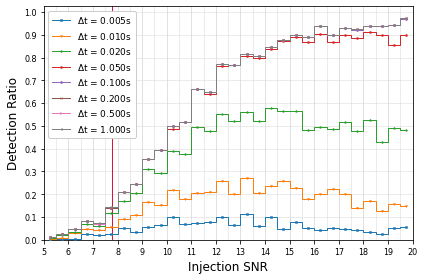

In [ ]:
###-----------------------------------------------------------------------------
#                        PLOT DR OVER SNR SCRIPT
###-----------------------------------------------------------------------------
from matplotlib.lines import Line2D
print('Reading in data...', end=' ', flush=True)
with open('/content/drive/MyDrive/TFM/results/U-Net_results/U_dr_over_snr.json', 'r') as json_file:
    results = json.load(json_file)
print('Done!', flush=True)

# Fix the data types
snr_bins = [(float(a), float(b)) for (a, b) in results['snr_bins']]
slack_widths = [float(_) for _ in results['detection_ratios'].keys()]

# -------------------------------------------------------------------------
# Actually make the plot: detection ratio over injection SNR
# -------------------------------------------------------------------------

# Define the markers we will be using for the plot (and make it cyclic)
def markers(index):
    markers_ = ['s', 'v', 'p', 'o', 'D', 'x', '>', '<']
    return markers_[index % len(markers_)]

# Get the bin centers for plotting
grid = [np.mean(_) for _ in snr_bins]

for i, slack_width in enumerate(sorted(slack_widths)):

    print(f'Creating plot for slack_width={slack_width:.3f}...', end=' ', flush=True)

    # Get the detection ratios for this slack_width value
    detection_ratios = results['detection_ratios'][str(slack_width)]
    detection_ratios = np.array(detection_ratios).astype(float)
    print(detection_ratios)

    # Make plot (plot step-function and actual data points)
    plt.plot(grid, detection_ratios, marker=markers(i), ms=2, mew=0.5, color=f'C{i}', linestyle='None', zorder=99)
    plt.step(grid, detection_ratios, where='mid', lw=1.0, color=f'C{i}', zorder=99)

    print('Done!', flush=True)

# Plot additional vertical lines to separate SNR bins
for x in np.unique(np.array(snr_bins).flatten()[1::2]):
    plt.axvline(x=x, color='#D9D9D9', lw=0.5, ls='-')

# Plot the PyCBC threshold for comparison
plt.axvline(x=np.sqrt(2 * 5.5**2), color='Crimson', lw=1.0)

# Set up axes ticks and limits
plt.xticks(np.linspace(5, 20, 16))
plt.yticks(np.linspace(0, 1, 11))
plt.xlim(5, 20)
plt.ylim(0.0, 1.025)

# Set up axes labels
plt.xlabel('Injection SNR', fontsize=12)
plt.ylabel('Detection Ratio', fontsize=12)

# Put a grid on the plot
plt.grid(which='both', ls='-', color='#D9D9D9', lw=0.5)

legend_elements = [Line2D([], [], ls='-', ms=2, mew=0.5, lw=1.0, color=f'C{i}', marker=markers(i), label=r'$\Delta$t = ' + f'{slack_width:.3f}s') for i, slack_width in enumerate(slack_widths)]
plt.legend(handles=legend_elements, loc='upper left', fontsize=9, framealpha=1)

# Adjust label sizes
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)

# Adjust the plot size
plt.tight_layout()
width = 8.6 / 2.54 / 1.015
plt.gcf().set_size_inches(6,4, forward=True)

# Construct path to save this plot
plots_dir = '/content/drive/MyDrive/TFM/results/U-Net_results/U_plots'
Path(plots_dir).mkdir(exist_ok=True)
file_path = os.path.join(plots_dir, 'U_dr_over_snr_1ch.pdf')

# Save the plot as a PDF
print('Saving plot as PDF...', end=' ', flush=True)
plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
print('Done!', flush=True)

In [ ]:
###--------------------------------------------------------------------------------------------
#                          COMPUTE DR OVER IFPR SCRIPT
###--------------------------------------------------------------------------------------------

config = get_config()

sample_length = config['static_args']['sample_length']

# Get the sampling rate of the examples (in Hertz)
sampling_rate = config['static_args']['sampling_rate']

# Get the "slack width", that is, the size of the interval around the
# ground truth injection time in which a detection will still be counted,
# and convert from seconds to time steps
slack_width = config['evaluation']['slack_width']['default']
slack_width = int(slack_width * sampling_rate)

# Get the number of seconds before the event in the examples, and the
# size of the receptive field of the model that was used
seconds_before_event = config['static_args']['seconds_before_event']
receptive_field_size = config['model']['receptive_field_size']

# Compute the time step at which the coalescence should be located in the
# model output for examples that contain an injection (taking into account
# that this prediction time series is shorter than the actual input by
# half the receptive field of the network)
event_index = int(seconds_before_event * sampling_rate)

predictions = dict(injection=None, noise=None)

# Open the predictions file and load the predictions
print('Loading predictions...', end=' ', flush=True)
with h5py.File('/content/drive/MyDrive/TFM/results/U-Net_results/U_predictions_testing_2ch_50ep.hdf', 'r') as hdf_file:
    predictions['injection'] = np.array(hdf_file['injection'])
    predictions['noise'] = np.array(hdf_file['noise'])
print('Done!')
print('')

# -------------------------------------------------------------------------
# Compute the DR and iFPR for different post-processing parameters
# -------------------------------------------------------------------------

# Define the thresholds and window sizes which we want to evaluate
thresholds = (0.1, 0.3, 0.5, 0.7, 0.9)
window_sizes = (1, 2, 4, 8, 16, 32, 64, 128, 256)

# Keep track of the results
results = list()

# Post-process the results for every parameter combination
print('Evaluating performance for different parameter combinations:\n')
for threshold in thresholds:
    for window_size in window_sizes:

        # Keep track of the numbers of false positives
        false_positives = dict(injection=list(), noise=list())

        # Process examples containing an injection
        detected_flags, false_positives['injection'] = \
                get_detections_and_fp(predictions=predictions['injection'],
                                      event_index=event_index,
                                      slack_width=slack_width,
                                      window_size=window_size,
                                      threshold=threshold)

        # Process examples containing only noise
        _, false_positives['noise'] = \
                get_detections_and_fp(predictions=predictions['noise'],
                                      event_index=None,
                                      slack_width=None)

        # Compute the global figures of merit
        figures_of_merit = get_dr_and_fpr(detected_flags=detected_flags,
                                              false_positives=false_positives,
                                              sample_length=sample_length)

        # Define shortcuts to figures of merit
        detection_ratio = figures_of_merit['detection_ratio']
        false_positive_ratio = figures_of_merit['false_positive_ratio']
        false_positive_rate = figures_of_merit['false_positive_rate']

        # Store the results so that we can save them for plotting
        results += [{'det_ratio': detection_ratio,
                         'fp_rate': false_positive_ratio,
                         'ifp_rate': 1.0 / false_positive_rate,
                         'fp_ratio': false_positive_ratio,
                         'threshold': threshold,
                         'window_size': window_size}]

        # Print results to command line
        print(f'THRESHOLD = {threshold}, '
                  f'WINDOW_SIZE = {window_size:3}'
                  f'   =>   '
                  f'DR = {detection_ratio:5.4f}, '
                  f'iFPR = {1.0 / false_positive_rate:9.4f}s')
    print('')

# -------------------------------------------------------------------------
# Create pandas data frame from results and save them as JSON
# -------------------------------------------------------------------------

# Create the data frame with all results and save it as a JSON file
print('Saving results to JSON file...', end=' ', flush=True)
dataframe = pd.DataFrame(results)
dataframe.to_json(path_or_buf='/content/drive/MyDrive/TFM/results/U-Net_results/U_dr_over_ifpr_2ch_50ep.json',
                      orient='records',
                      lines=True)
print('Done!')

Loading predictions... Done!

Evaluating performance for different parameter combinations:



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


dict_values([array([ 7,  9,  7, ...,  9, 14,  8]), array([0, 0, 0, ..., 0, 0, 0])])
THRESHOLD = 0.1, WINDOW_SIZE =   1   =>   DR = 0.8960, iFPR =    1.4841s
dict_values([array([ 6,  5,  7, ...,  5, 10,  4]), array([0, 0, 0, ..., 0, 0, 0])])
THRESHOLD = 0.1, WINDOW_SIZE =   2   =>   DR = 0.8888, iFPR =    2.0926s
dict_values([array([5, 4, 4, ..., 5, 7, 3]), array([0, 0, 0, ..., 0, 0, 0])])
THRESHOLD = 0.1, WINDOW_SIZE =   4   =>   DR = 0.8790, iFPR =    2.8652s
dict_values([array([4, 3, 3, ..., 1, 6, 3]), array([0, 0, 0, ..., 0, 0, 0])])
THRESHOLD = 0.1, WINDOW_SIZE =   8   =>   DR = 0.8677, iFPR =    4.4098s
dict_values([array([3, 2, 0, ..., 1, 4, 2]), array([0, 0, 0, ..., 0, 0, 0])])
THRESHOLD = 0.1, WINDOW_SIZE =  16   =>   DR = 0.8529, iFPR =    7.2156s
dict_values([array([2, 1, 0, ..., 1, 3, 2]), array([0, 0, 0, ..., 0, 0, 0])])
THRESHOLD = 0.1, WINDOW_SIZE =  32   =>   DR = 0.8395, iFPR =   12.3315s
dict_values([array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 0, 0, 0])])
THRE

Reading in data... Done!
Creating plot... Done!
Saving plot as PDF... Done!


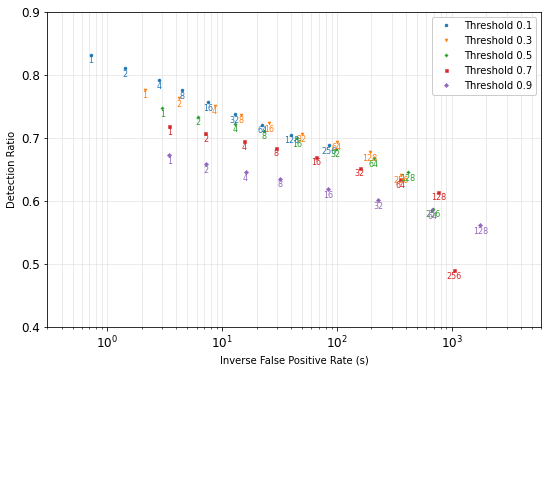

In [ ]:
###---------------------------------------------------------------------------
#                PLOT IFPR OVER SNR SCRIPT
###---------------------------------------------------------------------------

# Read in the results as a dataframe and fix some data types
print('Reading in data...', end=' ', flush=True)
dataframe = pd.read_json(path_or_buf='/content/drive/MyDrive/TFM/results/U-Net_results/U_dr_over_ifpr.json',
                             orient='records',
                             lines=True)
dataframe = dataframe.astype({"det_ratio": float,
                                  "fp_rate": float,
                                  "threshold": float,
                                  "window_size": int})
dataframe['threshold'] = np.around(dataframe['threshold'], decimals=1)
print('Done!', flush=True)

# Extract the values for the thresholds and window sizes
thresholds = sorted(np.unique(dataframe['threshold'].values))
window_sizes = sorted(np.unique(dataframe['window_size'].values))

# -------------------------------------------------------------------------
# Create the parametrized plot
# -------------------------------------------------------------------------

# Set up the subplots
fig, ax = plt.subplots(nrows=1)

# Define the markers we will be using for the plot (and make it cyclic)
def markers(index):
    markers_ = ['o', 'v', 'P', 's', 'D', 'x']
    return markers_[index % len(markers_)]

# Plot a line for every threshold value
print('Creating plot...', end=' ', flush=True)
for i, threshold in enumerate(thresholds):

    # Select the line for this threshold value
    line = dataframe[dataframe['threshold'] == threshold]

    # Keep track of all data points on that line
    X, Y = [], []

    # Select datapoints on that line from the dataframe
    for window_size in window_sizes:
        datapoint = line.loc[line['window_size'] == window_size]
        X.append(datapoint['ifp_rate'].values[0])
        Y.append(datapoint['det_ratio'].values[0])

    # Annotate each data point with corresponding the window size
    for x, y, window_size in zip(X, Y, window_sizes):
        ax.plot(x, y, color=f'C{i}', marker=markers(i), ms=3, mew=0.5)
        ax.annotate('{}'.format(window_size), xy=(x, y), xytext=(0, -5.5),
                        ha='center', va='center', textcoords='offset points',
                        fontsize=8, color=f'C{i}')
print('Done!', flush=True)

# -------------------------------------------------------------------------
# Set up options for the plot
# -------------------------------------------------------------------------

# Set up axes limits
plt.xlim(3e-1, 6e3)
plt.ylim(0.4, 0.9)

# Set up axes scales
plt.xscale('log')

# Set up axes labels
plt.xlabel('Inverse False Positive Rate (s)', fontsize=10)
plt.ylabel('Detection Ratio', fontsize=10)

# Put a grid on the plot
plt.grid(which='both', ls='-', color='#D9D9D9', lw=0.5)

# Adjust label sizes
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

# Add a custom legend to the plot
legend_elements = [Line2D([], [], label=f'Threshold {threshold}',
                              color=f'C{i}', marker=markers(i), ls='None',
                              mew=0.5, ms=3)
                       for i, threshold in enumerate(thresholds)]
plt.legend(handles=legend_elements, loc='upper right',
               fontsize=10, framealpha=1)

# Adjust the plot size
plt.tight_layout()
width = 8.6 / 2.54 / 1.025
fig.set_size_inches(8, 8, forward=True)

# Construct path for this plot file
plots_dir = './plots'
Path(plots_dir).mkdir(exist_ok=True)
file_path = os.path.join(plots_dir, 'U_dr_over_ifpr_1ch.pdf')

# Save the plot at the constructed location (as a PDF)
print('Saving plot as PDF...', end=' ', flush=True)
plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
print('Done!', flush=True)

sw: [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
fpr: [0.04740906 0.0398941  0.02072906 0.00105286 0.00032043 0.00032043
 0.00031281 0.00029755]
ifpr: [  21.09301577   25.06636068   48.24144277  949.79710145 3120.76190476
 3120.76190476 3196.87804878 3360.82051282]
Saving plot as PDF... Done!


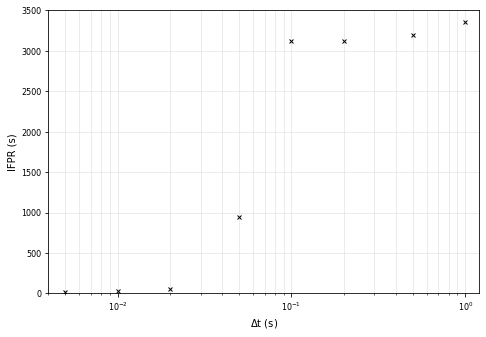

In [ ]:
###--------------------------------------------------------------------------
#           PLOT IFPR OVER DELTA T
###--------------------------------------------------------------------------
config = get_config()

# -------------------------------------------------------------------------
# Load the data from the HDF file
# -------------------------------------------------------------------------

# Get the "slack widths", that is, the sizes of the interval around the
# ground truth injection time in which a detection will still be counted.
# Note: The size is given in seconds and must be converted to time steps
# by multiplying with the sampling rate.
slack_widths = config['evaluation']['slack_width']['all']
slack_widths = sorted(np.unique(np.array(slack_widths).astype(float)))
print("sw:", slack_widths)
    # Initialize a list for the false positive rates
fpr_values = list()

    # Load the data from the HDF file
with h5py.File('/content/drive/MyDrive/TFM/results/U-Net_results/U_found_triggers_2ch_50ep.hdf', 'r') as hdf_file:

        # Loop over all slack_width values
    for slack_width in slack_widths:

            # Define a shortcut
        sw = str(slack_width)

            # Get the false positive rate for the current slack width
        fpr_values.append(float(hdf_file[sw]['figures_of_merit']
                                    .attrs['false_positive_rate']))

    # Convert list to a numpy array
fpr_values = np.array(fpr_values)
print("fpr:",fpr_values)
print("ifpr:", 1.0/fpr_values)
    # -------------------------------------------------------------------------
    # Create the plot: IFPR over \Delta t (slack_width)
    # -------------------------------------------------------------------------

plt.plot(slack_widths, 1.0 / fpr_values, 'x', ms=3.5, color='black')

    # -------------------------------------------------------------------------
    # Set up global options for the plot
    # -------------------------------------------------------------------------

plt.xscale('log')
plt.xlim(4e-3, 1.2e0)
plt.ylim(0, 3500)

    # Set up axes labels
plt.xlabel(r'$\Delta$t (s)', fontsize=10)
plt.ylabel('IFPR (s)', fontsize=10)

    # Put a grid on the plot
plt.grid(which='both', ls='-', color='#D9D9D9', lw=0.5)

    # Adjust label sizes
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)

    # Adjust the plot size
plt.tight_layout()
width = 8.6 / 2.54 / 1.015
plt.gcf().set_size_inches(7, 5, forward=True)

    # Construct path to save this plot
plots_dir = './plots'
Path(plots_dir).mkdir(exist_ok=True)
file_path = os.path.join(plots_dir, 'U_ifpr_over_delta_t_2ch.pdf')

    # Save the plot as a PDF
print('Saving plot as PDF...', end=' ', flush=True)
plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
print('Done!', flush=True)

In [ ]:
length = len(train_Loss_list)
x = range(0, length)
plt.plot(x, train_Loss_list, label='train loss')
plt.plot(x, valid_Loss_list, label='valid loss')
plt.title('Convolutional Neural Network')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()
#plt.savefig("cnn_loss.jpg")
plt.show()

In [ ]:
length = len(accuracy_list)
x = range(0, length)
plt.plot(x, accuracy_list)
plt.title('Convolutional Neural Network')
plt.xlabel('iteration')
plt.ylabel('accracy')
#plt.savefig("cnn_loss.jpg")
plt.show()

NameError: ignored

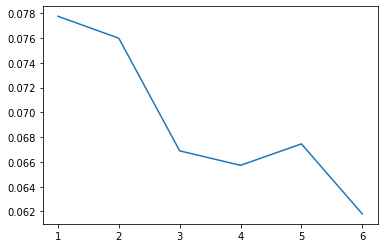

In [ ]:
t_l=[0.2544881510734558, 0.20931603506207466, 0.1861849719285965, 0.1773654879629612, 0.1725832736492157, 0.16759665802121163]
v_l=[0.07776305009610951, 0.07598937844159082, 0.06689364521298558, 0.06572379521094263, 0.06745461671380326, 0.061798984941560775]
x=[1,2,3,4,5,6]
#plt.plot(x,t_l)
plt.plot(x,v_l)
plt.show()